# Using Amazon SageMaker in Quantitative Finance

### Author: Gustavo Soares

This note book introduces the use of Amazon's SageMaker service for Finance.

## What is SageMaker?

SagemMaker is a service provided by AWS that combines two useful tools:

1. Managed Jupyter Notebook instances run remotely on a virtual machine hosted by Amazon (as opposed to on your personal computer for example)
2. API to very sophisticated tools commonly used in performing computationally difficult tasks often used when deploying Machine Learning models in Finance

## Why use SageMaker?

SagemMaker makes using Machine Learning techniques very easy. As you know, Jupyter Notebooks are typically where we first start testing out ideas in Quantitative Finance and where we can interactively run code before moving on to more sophisticated code structures and/or machinary. We can use SageMaker´s Managed Jupyter Notebook to explore and process the data and then use the API to simplify the development, training, validation and evaluation of the model.

While there are many way in which we can use Jupyter Notebooks to deal with the data and the initial steps of the modeling process, SageMaker´s API is quite helpful in the training and inferece process in data science.

## Training a quantitative trading strategy

When we create a strategy, we make some choices such as the type of signal, the sizing of the trades, the lookback window for estimating parameters such as volatility and past returns, etc.

Often, we want to make those choices in a way that our quantitative trading strategy meets certain criteria such as having the best performance conditional on some risk and leverage constraints. This process is called *training* and it often requires some *training data* to be carried out. As going through the different choices of parameters can be a computationally intensive exercise, SageMakers API can make the *training* of a strategy quite easy and carried out in a virtual machine.

Once the strategy has been trained, the chosen parameters will define the *model*. New data can be used as input in the model and the model will spit out suggested trades or the actual trading order themselves. Generically, let´s call these *model results*.

## Before we start

Before we start, you need to be sure you have an AWS account before you can access the [AWS console](https://console.aws.amazon.com/) where you can access all of the various Amazon Web Services, including SageMaker.

#### Setting up a Notebook Instance
The first thing we are going to need to do is set up a notebook instance.

1. Open the SageMaker dashboard, selecting **Notebook Instances** and clicking on **Create notebook instance**. You may choose any name you would like for your notebook. Also, using ml.t2.medium should be all that is necessary for now but take a look at the note on GPU´s below
2. Under IAM role select **Create a new role**. The only change that needs to be made is to select None under S3 buckets.
3. Once your notebook instance has started and is accessible, click on open to get to the Jupyter notebook main page.
4. On the **Actions** list select **Open Jupyter** to get to your Jupyter session.

###### Note on Graphics Processing Unit (GPU)
The Central Processing Unit (CPU) combines the arithmetic logic unit (ALU) accustomed quickly to store the information and perform calculations and Control Unit (CU) for performing instruction sequencing as well as branching. CPU interacts with more computer components such as memory, input and output for performing instruction. The Graphics Processing Unit (GPU) is used to provide the images in computer games. GPU is faster than CPU’s speed and it emphasis on high throughput. It’s generally incorporated with electronic equipment for sharing RAM with electronic equipment that is nice for the foremost computing task. It contains more ALU units than CPU.

The basic difference between CPU and GPU is that CPU emphasis on low latency. Whereas, GPU emphasis on high throughput. This is often importat in data science and therefore the use of GPU´s is quite common. You do not need access to GPU enabled compute instances here. However, having access to GPU enabled compute instances will increase the speed with which you can train your model significantly.

#### Import FinanceHub
The easiest way to make FinanceHub functinality available inside of your notebook instance is to use git and clone the repository.

1. Go to **New** and select **Terminal**
2. Switch to SageMaker directory by typing **cd SageMaker/**
3. Now clone FinanceHub´s repository by typing **git clone https://github.com/Finance-Hub/FinanceHub.git**
4. Close the terminal window.

#### Create new or upload notebook

To create a brand new notebook go to **New** and select **conda_python3**. If you prefer to upload an existing notebook, like this one, you can use the **Upload** bottom but make sure you have **conda_python3** selected as your kernel.

#### Create data directory and upload tracker data to it

1. Go to **New** and select **Folder**
2. Click on **Untitled Folder** and rename it to **fin_quant_data**
3. Go to the **fin_quant_data** directory click on **Upload** and upload the file **set_of_trackers.csv** 

## Getting started

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need and the original data:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
%matplotlib inline

Load the the time series data. This data consists of 112 financial time series. Each one of them starts at a different date. The largest time series has 5350 data points and the shortest one has only 1736 datapoints. The first column of the file is the date column and we will use that as the dataframe index: 

In [2]:
pathname = r'/home/ec2-user/SageMaker/fin_quant_data'
filename = os.path.join(pathname,'set_of_trackers.csv')
df = pd.read_csv(filename,index_col=0)
df.shape

(5350, 112)

#### Generating time series attributes

Let's start looking at the first time series to make the example more concrete:

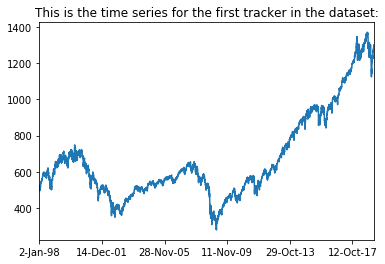

In [3]:
tracker_series = df.iloc[:,0]
tracker_series.plot(title='This is the time series for the first tracker in the dataset:')
plt.show()

On each particular date $t$, we want to predict the returns of a particular investment horizon of $h$ business days. Let say we want to do that with a basic trend-following model that combines different momentum signals, using different lookback windows. Since each tracker has a different volatility, let's think about volatility adjusted future returns and volatility adjusted momentum signals:

In [4]:
h = 21 # this is the number of bdays to be calcualted in the future returns

# move the time series back by h days and calcualte the returns over h days and the shift by one
# to account for a day lag in between calculating the signals and computing the target returns
daily_sigma = np.log(tracker_series).diff(1).std()
y = tracker_series.shift(-h).pct_change(h).shift(-1)
X = y.to_frame('future_returns')/(daily_sigma*np.sqrt(h)) # store and vol adjust

lookback_periods = [1,5,10,21,42,63,126,252] # set here the different momentum lookback windows you want to have
for m in lookback_periods:
    past_ret = tracker_series.pct_change(m).to_frame('m' + str(m)) # get the past returns for that lookback window
    past_ret = past_ret/(daily_sigma*np.sqrt(m)) # vol adjust
    X = pd.concat([X,past_ret],join='outer',axis=1,sort=0).fillna(method='ffill') # concatenate in the same dataframe
X = X[X['future_returns'].abs()>1e-10].dropna() # drop zero return periods and nan's
X.head()

,future_returns,m1,m5,m10,m21,m42,m63,m126,m252
31-Dec-98,0.356444,0.227295,0.901290,1.576246,1.095413,1.479014,2.502539,0.401126,1.116836
4-Jan-99,0.365994,-0.306724,-0.050834,1.478155,0.833686,1.223029,2.222613,0.296555,1.079280
5-Jan-99,-0.295961,0.823411,0.410624,1.344185,1.052642,1.453823,2.586649,0.386828,1.246233
6-Jan-99,-0.486646,1.789903,0.758113,1.821337,1.793783,1.623970,2.870574,0.503173,1.365461
7-Jan-99,-0.560620,-0.155758,1.067817,1.366981,1.298331,1.393523,3.053528,0.538345,1.440788


Let's put that in a function and run over all the time series we have:

In [5]:
def get_series_data(tracker_series, lookback_periods = [1,5,10,21,42,63,126,252],h = 21):
    # move the time series back by h days and calcualte the returns over h days and the shift by one
    # to account for a day lag in between calculating the signals and computing the target returns
    daily_sigma = np.log(tracker_series).diff(1).std()
    y = tracker_series.shift(-h).pct_change(h).shift(-1)
    X = y.to_frame('future_returns')/(daily_sigma*np.sqrt(h)) # store and vol adjust

    for m in lookback_periods:
        past_ret = tracker_series.pct_change(m).to_frame('m' + str(m)) # get the past returns for that lookback window
        past_ret = past_ret/(daily_sigma*np.sqrt(m)) # vol adjust
        X = pd.concat([X,past_ret],join='outer',axis=1,sort=0).fillna(method='ffill') # concatenate in the same dataframe
    X = X[X['future_returns'].abs()>1e-10].dropna() # drop zero return periods and nan's
    return X

X_df = pd.DataFrame()
for tracker in df.columns:
    X = get_series_data(df[tracker])
    X_df = X_df.append(X.reset_index().drop('index',axis=1))
X_df.shape

(533575, 9)

## Splitting the data

Now that we have the data in this clean tabular format let's split the rows in the dataset up into train, test and validation sets:

In [6]:
# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df.iloc[:,1:],
                                                                            X_df[[X_df.columns[0]]],
                                                                            test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Uploading the data files to S3

In order to use SageMaker to train our model, we need to give it access to data by storing it in S3. In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3.

In [7]:
# Save test, train and validation data to csv files
# Make sure not to include header information or an index as this is required by the built in algorithms provided by Amazon
# Also, for the train and validation data, it is assumed that the first entry in each row is the target variable

X_test.to_csv(os.path.join(pathname, 'test.csv'), header=False, index=False)
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(pathname, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(pathname, 'train.csv'), header=False, index=False)

Let import the SageMaker API functions wer are going to need and start a SageMaker session.

In [8]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [9]:
prefix = 'momentum_with_regression_trees'
test_location = session.upload_data(os.path.join(pathname, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(pathname, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(pathname, 'train.csv'), key_prefix=prefix)

## Train the model

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. XGBoost is an machine learning algorithm for structured or tabular data. Here, we will treat XGBoost as a *black box*.

To construct the object which we want to train, we need to provide the location of the training code. Since we are using a built in algorithm this container is provided by Amazon. SageMaker provides a useful utility method called `get_image_uri` that constructs the image name for us. To use the `get_image_uri` method we need to provide it with our current region, which can be obtained from the session object, and the name of the algorithm we wish to use. In this notebook we will be using XGBoost however you could try another algorithm if you wish. The list of built in algorithms can be found in the list of [Common Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [10]:
# construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

Before asking SageMaker to begin the training the model we need to set the model hyperparameters. There are quite a few that can be set when using the XGBoost algorithm, below are just a few of them. If you would like to change the hyperparameters below or modify additional ones you can find additional information on the [XGBoost hyperparameter page](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [11]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

Now that we have our estimator object completely set up, it is time to train it. To do this we make sure that SageMaker knows our input data is in csv format and then execute the `fit()` method.

In [12]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-12-16 17:28:20 Starting - Starting the training job...
2019-12-16 17:28:21 Starting - Launching requested ML instances......
2019-12-16 17:29:26 Starting - Preparing the instances for training...
2019-12-16 17:30:18 Downloading - Downloading input data......
2019-12-16 17:31:16 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:31:18] 239521x8 matrix with 1916168 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:D

[157]#011train-rmse:0.897378#011validation-rmse:0.928329
[158]#011train-rmse:0.897143#011validation-rmse:0.928286
[159]#011train-rmse:0.89706#011validation-rmse:0.928302
[160]#011train-rmse:0.896893#011validation-rmse:0.928278
[161]#011train-rmse:0.896831#011validation-rmse:0.928299
[162]#011train-rmse:0.896463#011validation-rmse:0.928122
[163]#011train-rmse:0.896337#011validation-rmse:0.928118
[164]#011train-rmse:0.896196#011validation-rmse:0.92812
[165]#011train-rmse:0.895987#011validation-rmse:0.928048
[166]#011train-rmse:0.895633#011validation-rmse:0.927932
[167]#011train-rmse:0.895462#011validation-rmse:0.927908
[168]#011train-rmse:0.89537#011validation-rmse:0.927918
[169]#011train-rmse:0.8952#011validation-rmse:0.927888
[170]#011train-rmse:0.894965#011validation-rmse:0.927857
[171]#011train-rmse:0.894667#011validation-rmse:0.927689
[172]#011train-rmse:0.894547#011validation-rmse:0.927722
[173]#011train-rmse:0.8944#011validation-rmse:0.927696
[174]#011train-rmse:0.894245#011valida

## Test the model

Now that we have fit our model to the training data, using the validation data, we can test the model. First, we need to build a transformer object from our fit model:

In [13]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Next we ask SageMaker to begin a batch transform job using our trained model and applying it to the test data we previously stored in S3. We need to make sure to provide SageMaker with the type of data that we are providing to our model, in our case `text/csv`, so that it knows how to serialize our data. In addition, we need to make sure to let SageMaker know how to split our data up into chunks if the entire data set happens to be too large to send to our model all at once.

Note that when we ask SageMaker to do this it will execute the batch transform job in the background. Since we need to wait for the results of this job before we can continue, we use the `wait()` method. An added benefit of this is that we get some output from our batch transform job which lets us know if anything went wrong.

In [14]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

......................[2019-12-16 17:35:57 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2019-12-16 17:35:57 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-12-16 17:35:57 +0000] [15] [INFO] Using worker: gevent
[2019-12-16 17:35:57 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-16 17:35:57 +0000] [23] [INFO] Booting worker with pid: 23
[2019-12-16 17:35:57 +0000] [24] [INFO] Booting worker with pid: 24
[2019-12-16 17:35:57 +0000] [25] [INFO] Booting worker with pid: 25

2019-12-16T17:36:19.050:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2019-12-16:17:36:19:INFO] No GPUs detected (normal if no gpus installed)
[2019-12-16:17:36:19:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [16/Dec/2019:17:36:19 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-16:17:36:19:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [16/Dec/2019:17:36:19 +0000] "GET /exe

Now that the batch transform job has finished, the resulting output is stored on S3. Since we wish to analyze the output inside of our notebook we can use a bit of notebook magic to copy the output file from its S3 location and save it locally.

In [15]:
!aws s3 cp --recursive $xgb_transformer.output_path $pathname

download: s3://sagemaker-us-east-1-458137317502/sagemaker-xgboost-2019-12-16-17-32-33-205/test.csv.out to fin_quant_data/test.csv.out


To see how well our model works we can create a simple scatter plot between the predicted and actual values of future returns:

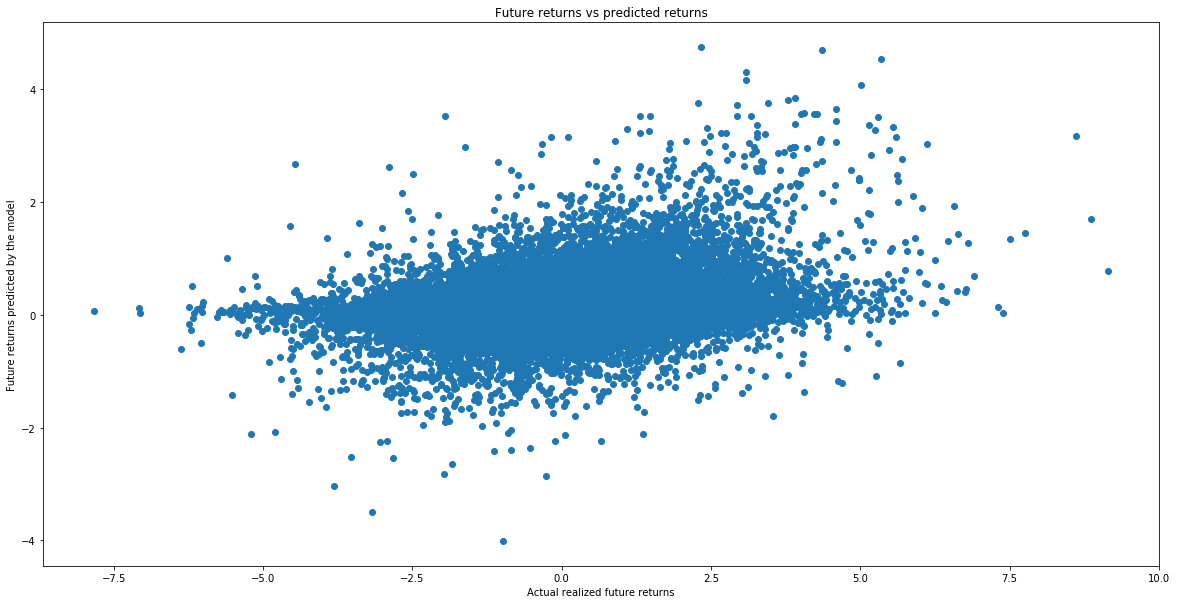

In [16]:
Y_pred = pd.read_csv(os.path.join(pathname, 'test.csv.out'), header=None)
plt.figure(figsize=(20,10))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual realized future returns")
plt.ylabel("Future returns predicted by the model")
plt.title("Future returns vs predicted returns")
plt.show()

As we can see, our model seems to have done okay, particularly in guessing the direction of the model but there is room for improvement.

## Clean up

The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

## Exercises

#### Beginners

Try to run this model for predicting future returns and create some analysis on the performance of the model in the test data that goes beyond simply plotting the scatter plot.

#### Intermediate

Try to run this model for predicting future returns direction, i.e., suppose you do not really care about predicting returns but only if the underlying asset will go up or down. Also, create some analysis on the performance of the model in the test data, like calculating the out of sample hit ratio of the model.

#### Advanced

Try to run this model for predicting future returns direction, i.e., suppose you do not really care about predicting returns but only if the underlying asset will go up or down. Also, maybe combine different definitions of momentum such as MACD or RSI together with standard momentum measures used here. Afterwards, create some analysis on the performance of the model in the test data, like calculating the out of sample hit ratio of the model.